In [1]:
import time
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm as tm
from src import Simulation as sim
from src import Dir_Reg as DR
from src import Dir_Reg_Adam as DR_A
from src import ABC_Reg
from src import Align
from src import visualize_latent_space as vls

from CLSNA import congress_utils as CU
from CLSNA.utils import visualize_membership, visualize
from scipy.spatial.distance import squareform

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cuda


In [2]:
def read_parameters(file_path):
    params = {}
    with open(file_path, 'r') as file:
        for line in file:
            name, value = line.strip().split('=')
            params[name] = int(value)  # Convert the value to an integer
    return params

# Read the value of N from the file
parameters = read_parameters('CLSNA/parameters.txt')
N_LEAVE = parameters.get('N_LEAVE')


def plot_lat_pos_CLSNA(df):
    """ the columns of df needs to be "time", "group", "dim_1", "dim_2", ...
    the function will plot the latent position at time 0 and 1"""
    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
    # Plot the first heatmap 
    sns.scatterplot(df[df["time"] == 0], ax = axes[0], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
    axes[0].set_title('Scatterplot Z0')
    axes[0].set_xlabel('Columns')
    axes[0].set_ylabel('Rows')
    axes[0].set_xlim(-0.2, 1.1)
    axes[0].set_ylim(-0.2, 1.1)
    # Add x = 0 (vertical line)
    axes[0].axvline(x=0, color='green', linestyle='--')
    # Add y = 0 (horizontal line)
    axes[0].axhline(y=0, color='green', linestyle='--')
    # Add y = 1 - x
    x_vals = np.array(axes[0].get_xlim())
    axes[0].plot(x_vals, 1 - x_vals, color='green', linestyle='--')

    # Plot the second heatmap 
    sns.scatterplot(df[df["time"] == 1], ax = axes[1], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
    axes[1].set_title('Scatterplot Z1')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Rows')
    axes[1].set_xlim(-0.2, 1.1)
    axes[1].set_ylim(-0.2, 1.1)
    # Add x = 0 (vertical line)
    axes[1].axvline(x=0, color='green', linestyle='--')
    # Add y = 0 (horizontal line)
    axes[1].axhline(y=0, color='green', linestyle='--')
    # Add y = 1 - x
    x_vals = np.array(axes[1].get_xlim())
    axes[1].plot(x_vals, 1 - x_vals, color='green', linestyle='--')
    
    
    plt.show()

In [3]:
# Set global variables for the model
N = 5000
DIM = 2
T = 2
SIGMA = 1
TAU = 1
PHI = 1
ALPHA = 1
DELTA = 0
GAMMAW = 0.5
GAMMAB = -1

In [4]:
z,y,persist,Aw,Ab,leaves = CU.congress_clsna(N=N, 
                                             d=DIM, 
                                             T=T, 
                                             alpha=ALPHA, 
                                             delta=DELTA, 
                                             sigma=SIGMA, 
                                             tau=TAU , 
                                             phi=PHI, 
                                             gammaw=GAMMAW, 
                                             gammab=GAMMAB, 
                                             n_leave=N_LEAVE)

In [5]:
# t0, t1 = T-9, T-8
t0, t1 = 0, 1

z = torch.tensor(np.array(z))
lat_pos = z[t0:(t1 + 1), :, :]
Z0, Z1 = lat_pos[0, :, :], lat_pos[1, :, :]
Y0, Y1 = torch.as_tensor(squareform(y[t0]), dtype = torch.float32), torch.as_tensor(squareform(y[t1]), dtype = torch.float32)

Visualize the latent position at time t

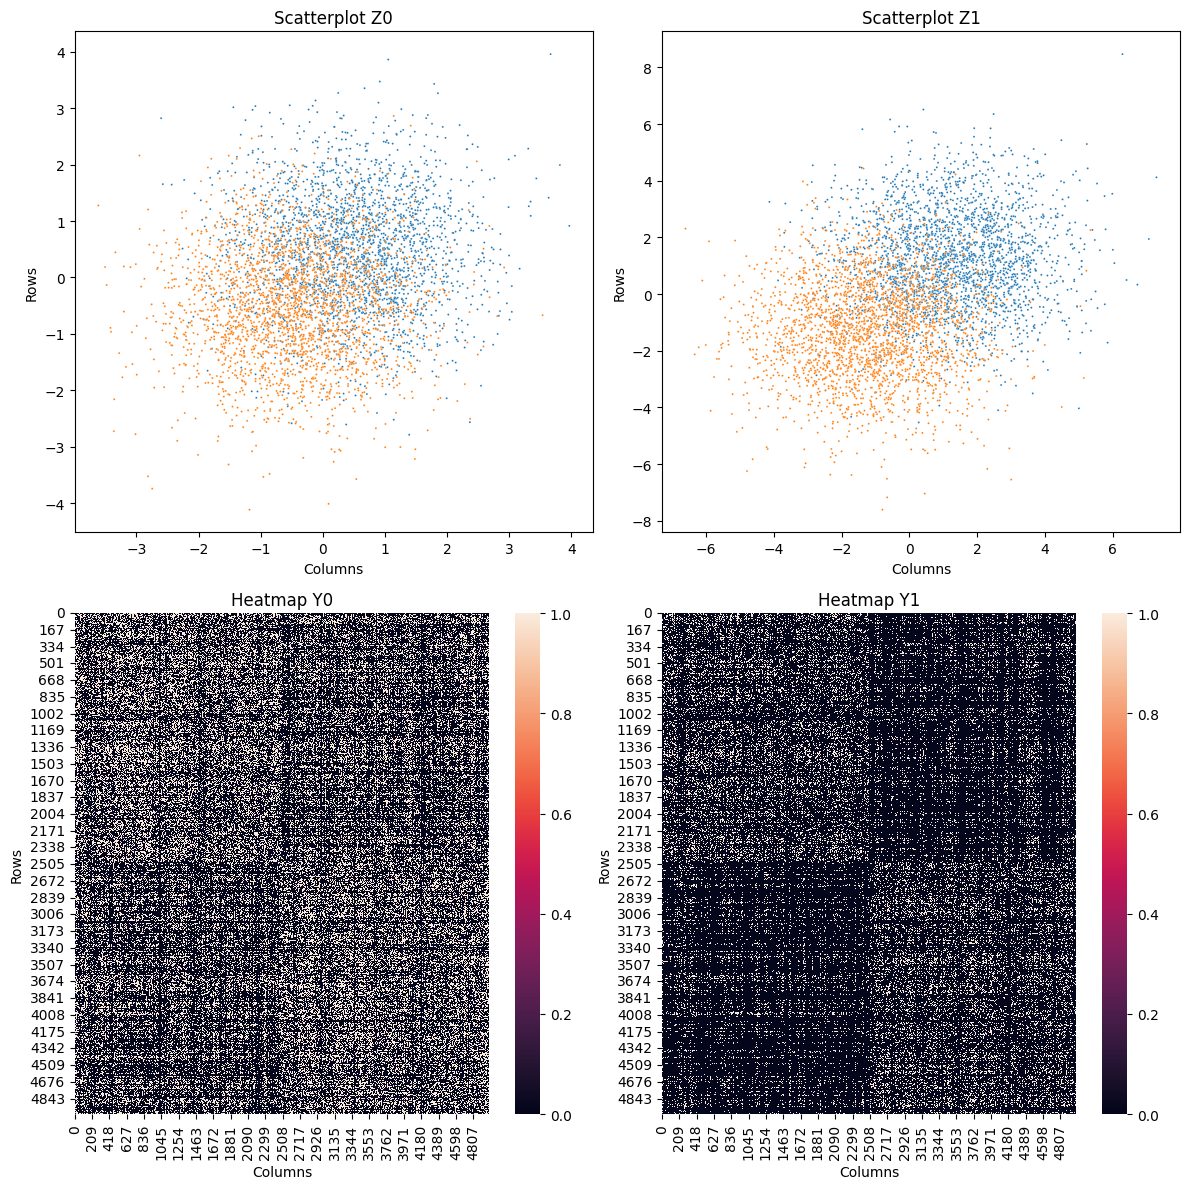

In [6]:
pd_df = sim.ABC_Monte_Carlo.lat_pos(lat_pos, 2)
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjust figsize as needed

# Plot the first heatmap 
sns.scatterplot(pd_df[pd_df["time"] == 0], ax = axes[0,0], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
axes[0,0].set_title('Scatterplot Z0')
axes[0,0].set_xlabel('Columns')
axes[0,0].set_ylabel('Rows')

# Plot the second heatmap 
sns.scatterplot(pd_df[pd_df["time"] == 1], ax = axes[0,1], x = "dim_1", y = "dim_2", s = 2, hue = "group", legend = False)
axes[0,1].set_title('Scatterplot Z1')
axes[0,1].set_xlabel('Columns')
axes[0,1].set_ylabel('Rows')

# Plot the first heatmap 
sns.heatmap(Y0, ax=axes[1, 0], cbar=True)
axes[1,0].set_title('Heatmap Y0')
axes[1,0].set_xlabel('Columns')
axes[1,0].set_ylabel('Rows')

# Plot the second heatmap 
sns.heatmap(Y1, ax=axes[1,1], cbar=True)
axes[1,1].set_title('Heatmap Y1')
axes[1,1].set_xlabel('Columns')
axes[1,1].set_ylabel('Rows')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
sv_Y0, sv_Y1 = torch.svd(Y0)[1], torch.svd(Y1)[1]

# Create scatter plot
sns.scatterplot(sv_Y0, s=5, color='teal', edgecolor='k')

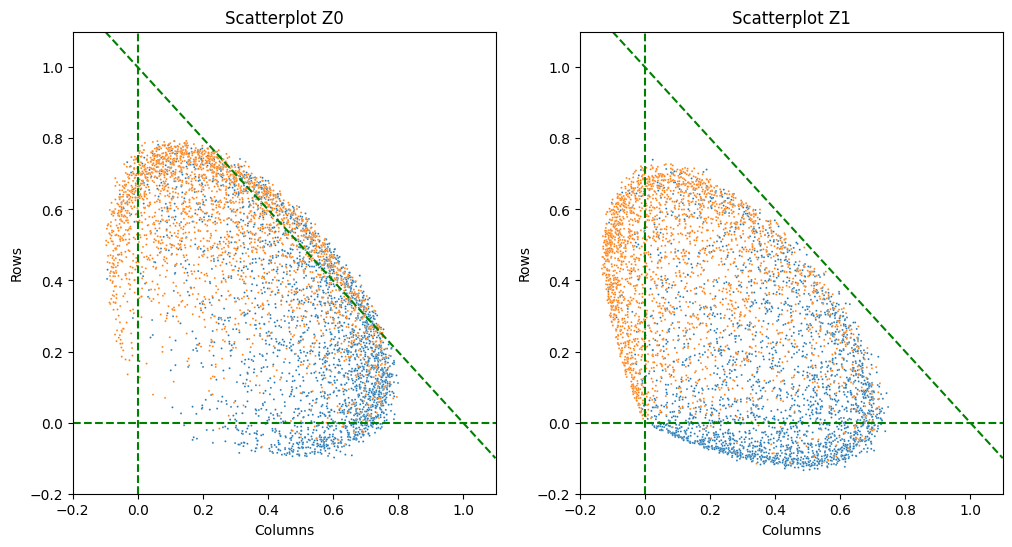

the estimated beta is tensor([ 2.5957,  1.6708, -1.7428,  6.5354]), the info lost is 0.44279999999999997, and GD took 182 iterations


In [31]:
# There are 2 groups, and we want to embed the adjacency matrix in R2
K, p = 2, 2

obs_adj = torch.cat([Y0.unsqueeze(dim=0), Y1.unsqueeze(dim=0)], dim=0)

estimate = ABC_Reg.est(two_adj_mat = obs_adj, groups = K, tol_est = 10e-5, tol_RGD = 10e-4)

estimate.specify_mode("NO", embed_dim= p)

# Here we extract our embeddings and plot them
Aligned = estimate.process("NO") 
Z0_A, Z1_A = Aligned['predictor'][:, 0:2], Aligned['response'][:, 0:2]
Z_Aligned = torch.cat([Z0_A.unsqueeze(dim = 0), Z1_A.unsqueeze(dim = 0)], dim = 0)
temp_df  = sim.ABC_Monte_Carlo.lat_pos(Z_Aligned, 2)

plot_lat_pos_CLSNA(temp_df)

# Print out the estimated beta
estimate.fitted.est_result['estimate']

beta_est = DR.fit.proj_beta(estimate.fitted.est_result["estimate"], DR.fit.gen_constraint(p+1, True))

print(f"the estimated beta is {beta_est}, the info lost is {estimate.fitted.est_result["info_lost"]}, and GD took {estimate.fitted.est_result['num_iter']} iterations")

As shown above, RGD is not really an option because we are losing about 40% of data in the best case scenario. To mitigate this data loss problem, we solve the penalized version of the embedding problem instead. 

Although the scree plot suggest that the adj mat can be embedded in higher dimension (>= 4), one issue is that the result becomes dependent to the initialization. With embeddings in R2 or R3, the beta estimate is stable (to the initialization for Dirichle Regression and to some level for hyperparameters of Embedding optimization), and it looks reasonable given the parameters from the CLSNA model. 

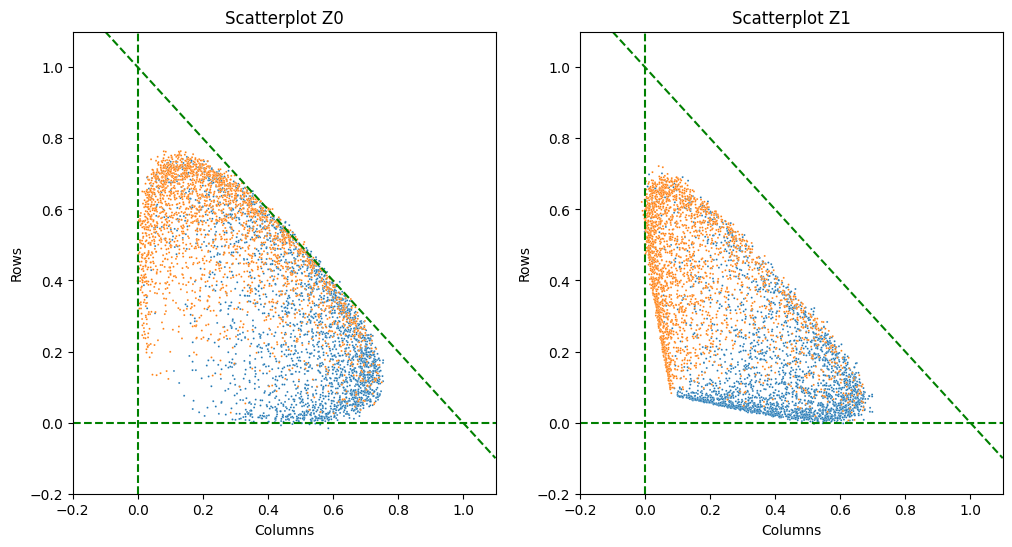

Using GD_ADAM: the estimated beta is tensor([ 0.6759,  0.8777, -0.5188,  0.2237]), the info lost is 0.0030000000000000027, and GD took 6885 iterations


In [ ]:
# There are 2 groups, and we want to embed the adjacency matrix in R2
K, p0 = 2, 2
obs_adj = torch.cat([Y0.unsqueeze(dim=0), Y1.unsqueeze(dim=0)], dim=0)

# Given the observed adjacency matrix, compute the ASE for initialization purposes
estimate = ABC_Reg.est(two_adj_mat = obs_adj, groups = K)
estimate.specify_mode("NO", fit = False, embed_dim= p0)

# Find a more usable embedding with penalized optimization
GD_Z0_Align = Align.GD_RDPG(Y0, N/7, estimate.raw_data.Z0_ASE[:, :p0], smoothing = 5, tol = 1e-1, verbose = False)
prev_lp = GD_Z0_Align.fitted.clone().detach().to(device)
GD_Z1_Align = Align.GD_RDPG(Y1, N/7, prev_lp, smoothing = 5, tol = 1e-1, verbose = False)

# Visualize the computed embeddings
GD_Z_Aligned = torch.cat([GD_Z0_Align.fitted.detach().unsqueeze(dim = 0), GD_Z1_Align.fitted.detach().unsqueeze(dim = 0)], dim = 0).cpu()
temp_df = sim.ABC_Monte_Carlo.lat_pos(GD_Z_Aligned, 2)
plot_lat_pos_CLSNA(temp_df)

# Use the embeddings obtained above, create the design and response matrix
estimate.input['latpos'] = GD_Z_Aligned
estimate.specify_mode(new_mode = "OL", fit = False, embed_dim = p0)

# Fit the model
beta_guess = torch.tensor([0, 0, 0, 0], dtype = torch.float32)
estimate_A = DR_A.fit(estimate.data['predictor'], estimate.data['response'], 
                      beta_guess = beta_guess,
                      tol = 0.1,
                      max_iter = 20000)
estimate_A.Dir_GD_unconstrained()

# Project the computed beta matrix to R4
beta_est = DR.fit.proj_beta(estimate_A.est_result["estimate"], DR.fit.gen_constraint(p0, True))
print(f"Using GD_ADAM: the estimated beta is {beta_est}, the info lost is {estimate_A.est_result["info_lost"]}, and GD took {estimate_A.est_result['num_iter']} iterations")

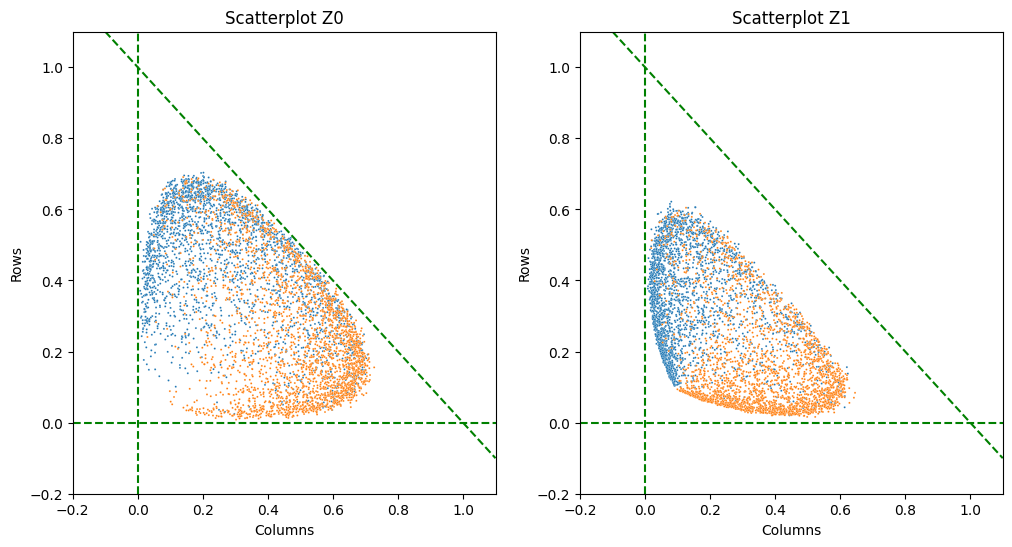

Using GD_ADAM: the estimated beta is tensor([ 0.9559,  0.4659, -3.3591,  0.1220]), the info lost is 0.0, and GD took 10357 iterations


In [ ]:
# The same stuff as above, but embedded in R3
K, p0 = 2, 3
obs_adj = torch.cat([Y0.unsqueeze(dim=0), Y1.unsqueeze(dim=0)], dim=0)

# Given the observed adjacency matrix, compute the ASE for initialization purposes
estimate = ABC_Reg.est(two_adj_mat = obs_adj, groups = K)
estimate.specify_mode("NO", fit = False, embed_dim= p0)

# Find a more usable embedding with penalized optimization
GD_Z0_Align = Align.GD_RDPG(Y0, N/4, estimate.raw_data.Z0_ASE[:, :p0], smoothing = 5, tol = 1e-1, verbose = False)
prev_lp = GD_Z0_Align.fitted.clone().detach().to(device)
GD_Z1_Align = Align.GD_RDPG(Y1, N/4, prev_lp, smoothing = 5, tol = 1e-1, verbose = False)

# Visualize the computed embeddings
GD_Z_Aligned = torch.cat([GD_Z0_Align.fitted.detach().unsqueeze(dim = 0), GD_Z1_Align.fitted.detach().unsqueeze(dim = 0)], dim = 0).cpu()
temp_df = sim.ABC_Monte_Carlo.lat_pos(GD_Z_Aligned, 2)
plot_lat_pos_CLSNA(temp_df)

# Use the embeddings obtained above, create the design and response matrix
estimate.input['latpos'] = GD_Z_Aligned
estimate.specify_mode(new_mode = "OL", fit = False, embed_dim = p0)

# Fit the model
beta_guess = torch.tensor([0, 0, 0, 0], dtype = torch.float32)
estimate_A = DR_A.fit(estimate.data['predictor'], estimate.data['response'], 
                      beta_guess = beta_guess,
                      tol = 0.1,
                      max_iter = 20000)
estimate_A.Dir_GD_unconstrained()

# Project the computed beta matrix to R4
beta_est = DR.fit.proj_beta(estimate_A.est_result["estimate"], DR.fit.gen_constraint(p0, True))
print(f"Using GD_ADAM: the estimated beta is {beta_est}, the info lost is {estimate_A.est_result["info_lost"]}, and GD took {estimate_A.est_result['num_iter']} iterations")

Initialized at a different point to demonstrate stability.

In [ ]:
# Fit the model with a different initialization
beta_guess = torch.tensor([1,1,1,1], dtype = torch.float32)
estimate_A = DR_A.fit(estimate.data['predictor'], estimate.data['response'], 
                      beta_guess = beta_guess,
                      tol = 0.1,
                      max_iter = 20000)
estimate_A.Dir_GD_unconstrained()

# Project the computed beta matrix to R4
beta_est = DR.fit.proj_beta(estimate_A.est_result["estimate"], DR.fit.gen_constraint(p0, True))
print(f"Using GD_ADAM: the estimated beta is {beta_est}, the info lost is {estimate_A.est_result["info_lost"]}, and GD took {estimate_A.est_result['num_iter']} iterations")

Using GD_ADAM: the estimated beta is tensor([ 0.9561,  0.4605, -3.3643,  0.3071]), the info lost is 0.0, and GD took 18629 iterations
